# Chapter 2 -- Pulse Interactions with Linear Media

In this chapter we explore the interaction of ultrafast pulses with linear media.  

In particular, we discuss: 

- Reflection and transmission elements
- Cavities
- Propagation in dispersive media (pulse stretching and compression)

## Materials and Notes

See Ch. 2 (2.6) of [Ultrafast Optics text from Franz Kaertner](https://ocw.mit.edu/courses/6-977-ultrafast-optics-spring-2005/f806ff596f9bffb74003360e2c05c086_MIT6_977S05_textbook.pdf).

Chapter 2 materials are in the google drive folder [here](https://drive.google.com/drive/folders/1Nu0RKroW_MXer--jxj98zGTdi_qBgWsi?usp=share_link). 

## Simulation and Computation 1: Fabry-Perot Cavity

Simulation and computational examples for this chapter follow.

### Headers, Packages, and Variables -- Run First!

The following code-block contains the packages, functions and variables needed for the code found later in this notebook.  It must be run first.  Note that if you are running this on your personal computer, you should ensure that all packages needed are installed first (for example the [numpy](https://numpy.org/), [scipy](https://scipy.org/), and [matplotlib](https://matplotlib.org/) packages must be installed on your computer along with others).  You can find a launcher link at the top to conveniently run this notebook in Google Colab.  

The code below is hidden by default, but you are encouraged to expand it and study it.  The functions and constants will update as needed during the progression of the course, so you should note what new functions have been and added and study how they work.  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets


#--Physical Constants--
hbar = 1.054e-34 #normalized Planck constant [J*s]
evcon = 1.602e-19 #conversion factor, [J/eV]
eta = 119.91699832*np.pi #impedance of freespace [ohms]
me = 9.10938188e-31 #mass of electron [kg]
c = 2.99792458e8 #speed of light [m/s]
e = 1.602e-19 #electron charge [C]

#--Gaussian Pulse Function --
def gaussian_pulse(t, fwhm, wc, phi_ce):
    """
    [E, A] = gaussian_pulse(t, fwhm, wc, phi_ce)

    Function for generating a Gaussian pulse form with given intensity FWHM.
    Outputs electric field profile and intensity envelope, both normalized to
    peak of 1.  Units need to be self-consistent between t, fwhm, and wc.

    Inputs:
    -----------
      t --> time 
      fwhm --> full width at half max of the intensity envelope
      wc --> central frequency (rad/unit time)
      phi_ce --> carrier envelope phase offset (rad)

    Outputs:
    -------------
      pulse['E'] --> Electric field profile (peak of 1)
      pulse['A'] --> Intensity envelope (peak of 1)
    
    """


    #Now determine constant for gaussian envelope from fwhm:
    tau = fwhm/(2*np.sqrt(np.log(2)));

    #Finally, define the pulse:
    E_envelope = np.exp(-t**2/(2*tau**2));
    
    pulse = {}

    pulse['E'] = E_envelope*np.cos(wc*t + phi_ce);

    pulse['A'] = E_envelope**2;
    
    return pulse

#Calculate index based on Sellmeier coefficients
# -- Assumes wavelength in microns
def n_sell(y, B, C):
    """
    Calculate index based on Sellmeier coefficients.
    
    Assumes wavelength y in microns.
    
    B and C should be vectors with equal number of coefficients.
    
    Based on forumlation here: https://en.wikipedia.org/wiki/Sellmeier_equation
    """
    
    n2 = np.ones(y.size)
    
    #We are only concerned with wavelengths > 0!
    y_valid = np.where(y > 0)
    
    for m in range(0, len(B)):
        
        n2[y_valid[0]] = n2[y_valid[0]] + B[m]*y[y_valid[0]]**2/(y[y_valid[0]]**2 - C[m])
        
    n = np.sqrt(np.abs(n2))
    
    return n
    

### Define and Plot E-Fields from a Pulse

We need to start by defining our pulse and its envelope. We can use the pre-defined function in the headers block above for that.

#### Time-Domain Fields

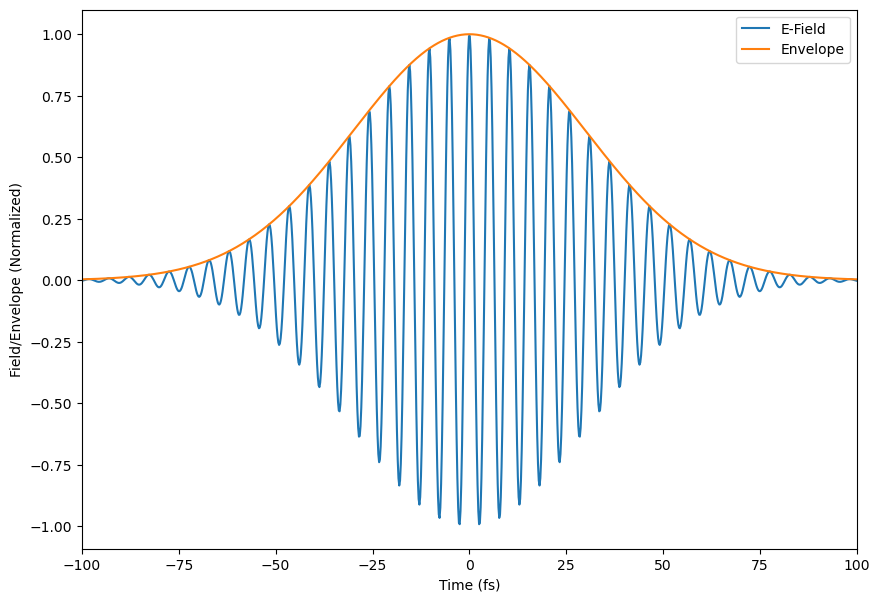

In [2]:
# -- Pulse Settings -- 
yc = 1.55 # central wavelength in micrometers
phi_ce = 0
fwhm = 50 #this one is in femtoseconds


# -- Calculations  -- 
t_ax = np.linspace(-1000, 1000, 10000) #time in fs
wc = 2*np.pi*c*1e-15/(yc*1e-6) # angular frequency in rad/fs
pulse = gaussian_pulse(t_ax, fwhm, wc, phi_ce) #pulse information
A = np.sqrt(pulse['A']) #code provides intensity envelope, we need to convert to field envelope...
E = pulse['E'] #Fields for reference

# -- Plotting -- 
fig = plt.figure()
fig.set_size_inches(10, 7)

plt.plot(t_ax, pulse['E'], label='E-Field')
plt.plot(t_ax, np.sqrt(pulse['A']), label='Envelope')

plt.xlim(-100, 100)
plt.legend()
plt.xlabel('Time (fs)')
plt.ylabel('Field/Envelope (Normalized)');

#### Frequency-Domain Representation

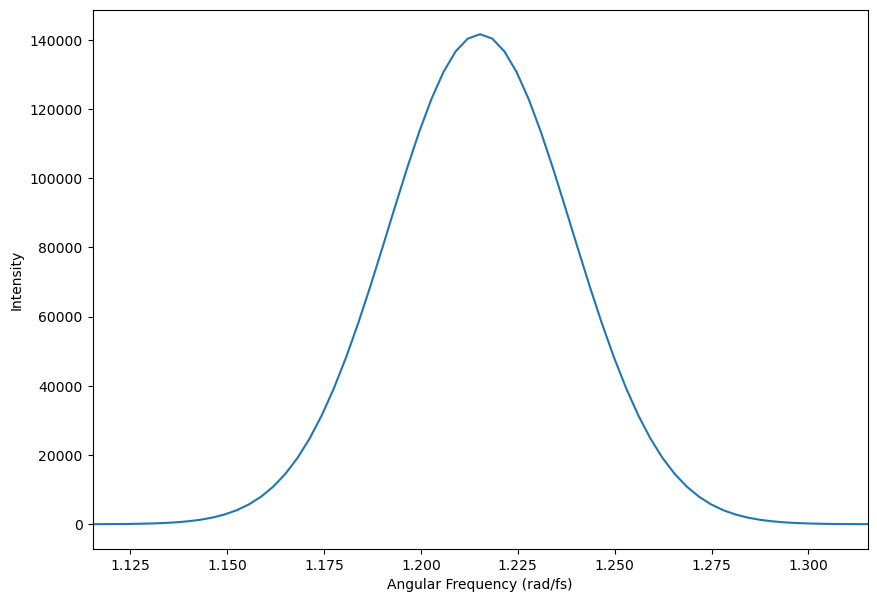

In [3]:
#Take the FT of the envelope
A_f = np.fft.fft(A)

#Define the frequency axis
dt = t_ax[1] - t_ax[0]
w = 2*np.pi*np.fft.fftfreq(pulse['E'].size, dt)

#Plot the result
fig = plt.figure()
fig.set_size_inches(10, 7)

plt.plot(np.fft.fftshift(w + wc), np.fft.fftshift(np.abs(A_f)**2))
plt.xlim(wc - 0.1, wc + 0.1)

plt.xlabel('Angular Frequency (rad/fs)')
plt.ylabel('Intensity');

### Fabry-Perot Cavity

Here we define the transfer function we derived for the Fabry-Perot cavity.  

We explicitly define the phase accumulated between the elements as `phi = k*L`.  This way we can play with the length of the Fabry-Perot cavity and observe the output pulse envelope.  

#### $H$ and Cavity Output When Driven by the Pulse

Here we calculate and examine the amplitude and phase of the complex transfer function of the cavity $H$, and the outgoing pulse in frequency and time. 

The code below is slightly more complicated as we use widgets to let us dynamically change parameters.  However, I think this is useful for your own simulations in the future so that you can see how different parameters change the behavior more easily.  

Some questions to think about:
 - How does $L$ control the spacing between the pass-band peaks?  Why?
 - What happens when the spacing $L$ is not an integer number of wavelengths (i.e. $L/\lambda \neq n$)?
 - What is the impact of the power reflectivity R on the pass-band response?  Why?
 - How might the Fabry-Perot cavity be leveraged for dispersion compensation?

In [4]:

# -- Code -- 
#See lecture notes for definitions here...
k = (w + wc)*1e15*1e-6/c #Be careful of units here!


def H_calc(R, L):
    
    T = 1 - R
    phi = -1*k*L

    H = -T*np.exp(1j*phi)*(1 - R*np.exp(-1j*2*phi))/(1 + R**2 - 2*R*np.cos(2*phi))
    
    return H


#We now define the plotting within a function.
#We do this as we are going to use interactive widgets to let us dynamically
#change parameters and replot.  This can be very useful for visualization
#and study.  
def update(R, L):
    
    H = H_calc(R, L)
    
    #Calculate outputs:
    A_out_f = A_f*H
    A_out = np.fft.ifft(A_out_f)
    
    #Update plots
    fig = plt.figure()
    fig.set_size_inches(7.5, 15)
    
    ax = []
    ax.append(fig.add_subplot(4,1,1))
    ax.append(fig.add_subplot(4,1,2))
    ax.append(fig.add_subplot(4,1,3))
    ax.append(fig.add_subplot(4,1,4))
    
    # -- Plot |H|^2 --
    ax[0].plot(np.fft.fftshift(w + wc), np.abs(np.fft.fftshift(H))**2)
    ax[0].set_xlim(wc - 0.1, wc + 0.1)
    ax[0].set_xlabel('Angular Frequency (rad/fs)')
    ax[0].set_ylabel('|H|^2')

    # -- Plot arg(H) --
    ax[1].plot(np.fft.fftshift(w + wc), np.angle(np.fft.fftshift(H)))
    ax[1].set_xlim(wc - 0.1, wc + 0.1)
    ax[1].set_xlabel('Angular Frequency (rad/fs)')
    ax[1].set_ylabel('arg(H) (rad)')

    #-- Plot Frequency Spectrum of Transmitted Pulse -- 
    ax[2].plot(np.fft.fftshift(w + wc), np.abs(np.fft.fftshift(A_out_f))**2)
    ax[2].set_xlim(wc - 0.1, wc + 0.1)
    ax[2].set_xlabel('Angular Frequency (rad/fs)')
    ax[2].set_ylabel('|A_out_f|^2')

    #-- Plot Outgoing Pulse Intensity in Time --
    ax[3].plot(t_ax, np.abs(A_out)**2)
    ax[3].set_xlabel('Time (fs)')
    ax[3].set_ylabel('A_out^2')


    
ipywidgets.interact(update, L=ipywidgets.FloatText(value=10), R=ipywidgets.FloatSlider(min=0.0, max=0.99, value=0.5, step=0.01))

interactive(children=(FloatSlider(value=0.5, description='R', max=0.99, step=0.01), FloatText(value=10.0, desc…

<function __main__.update(R, L)>

## Simulation and Computation 2: Pulse Propagation in Dispersive Media

### Define and Plot E-Fields from a Pulse

We need to start by defining our pulse and its envelope. We can use the pre-defined function in the headers block above for that.

In [5]:
# -- Pulse Settings -- 
yc = 1.55 # central wavelength in micrometers
phi_ce = 0
fwhm = 30 #this one is in femtoseconds
N = 10000

#We now define the plotting within a function.
#We do this as we are going to use interactive widgets to let us dynamically
#change parameters and replot.  This can be very useful for visualization
#and study.  


def update(fwhm, yc, phi_ce):

    # -- Plotting -- 
    fig = plt.figure()
    fig.set_size_inches(10, 7)
    
    # -- Calculations  -- 
    t_ax = np.linspace(-fwhm*50, fwhm*50, N) #time in fs
    
    wc = 2*np.pi*c*1e-15/(yc*1e-6) # angular frequency in rad/fs
    
    pulse = gaussian_pulse(t_ax, fwhm, wc, phi_ce*np.pi) #pulse information
    A = np.sqrt(pulse['A']) #code provides intensity envelope, we need to convert to field envelope...
    E = pulse['E'] #Fields for reference



    plt.plot(t_ax, pulse['E'], label='E-Field')
    plt.plot(t_ax, np.sqrt(pulse['A']), label='Envelope')

    plt.xlim(-4*fwhm, 4*fwhm)
    plt.legend()
    plt.xlabel('Time (fs)')
    plt.ylabel('Field/Envelope (Normalized)')
    

    return wc, fwhm, t_ax, A, E

pulse_set = ipywidgets.interactive(update, 
                    fwhm=ipywidgets.FloatText(value=fwhm, description='FWHM (fs)'),
                    yc=ipywidgets.FloatText(value=yc, description = '$\lambda_c$ ($\mu$m)'),
                    phi_ce=ipywidgets.FloatText(value=phi_ce, description = '$\phi_{\mathrm{ce}}$ ($\pi$ rad)'))


display(pulse_set)

interactive(children=(FloatText(value=30.0, description='FWHM (fs)'), FloatText(value=1.55, description='$\\la…

### Frequency-Domain Representation 

The code below shows the frequency domain form of the pulse for visualization.

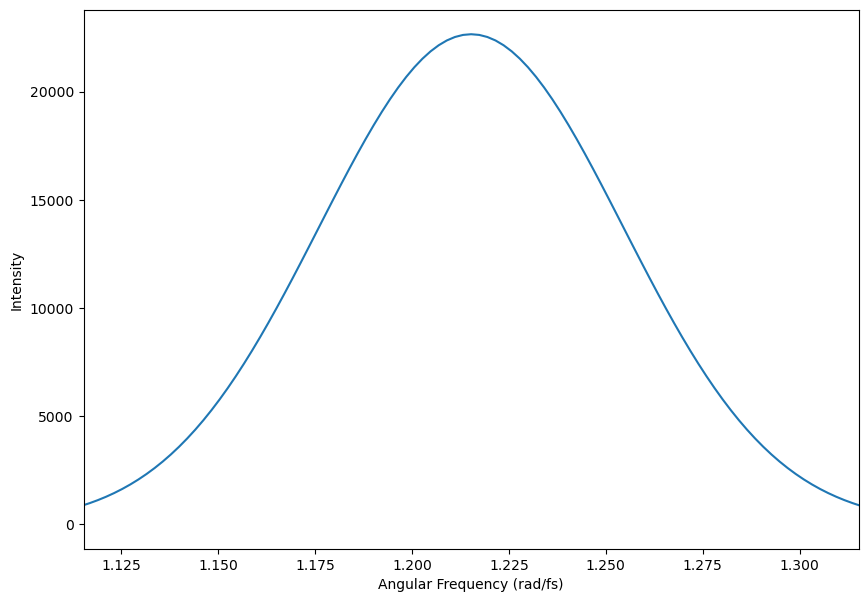

In [6]:
#Retrieve values after setting pulse above
wc, fwhm, t_ax, A, E = pulse_set.result

#Take the FT of the envelope
A_f = np.fft.fft(A)

#Define the frequency axis
dt = t_ax[1] - t_ax[0]
w = 2*np.pi*np.fft.fftfreq(E.size, dt)

#Plot the result
fig = plt.figure()
fig.set_size_inches(10, 7)

plt.plot(np.fft.fftshift(w + wc), np.fft.fftshift(np.abs(A_f)**2))
plt.xlim(wc - 0.1, wc + 0.1)

plt.xlabel('Angular Frequency (rad/fs)')
plt.ylabel('Intensity');


### Impact of Material Dispersion on Pulse Propagation

Here we can continue the concept of a transfer function to help us understand the impact of dispersion on pulse propagation through a medium.

For the FP cavity above, there was an influence on the output pulse's amplitude and phase after propagation. Both the amplitude reshaping and the phase dispersion impact the output pulse shape.  However, for a transparent dispersive medium this impact is primarily within the phase of the pulse. As discussed in the lecture, a medium that exhibits a high dispersion in phase after propagation (that is the accumulated phase changes significantly as a function of frequency) can also have a significant impact on the outgoing pulse shape.

As discussed in lecture, we can write the effect of material dispersion as a polynomial series in phase.

$\varphi(\omega) = \varphi_1 \omega + \frac{1}{2}\varphi_2 \omega^2 + \frac{1}{6}\varphi_3 \omega^3 + ... + \frac{1}{N!}\varphi_N \omega^N $

Note here that we are speaking of $\omega = \Omega - \omega_0$ as being the frequency space of the envelope, where $\Omega$ is the absolute frequency of the electric field pulse, and $\omega_0$ is the central frequency.  We discussed this in the first recitation, and this trick is used a lot to help us numerically (because it avoids very rapidly oscillating terms).   Note that in the code we mostly use the envelop form denoted as `w` with the central frequency denoted as `wc`.  

### Study Impact of Higher-Order Dispersion


In the interactive code below, you can set values of $\varphi_N$ for orderst 2, 3, and 4 and observe the impact on the transformed pulse. Note that we disregard $\varphi_1$ as it simply corresponds to a time shift.

In [7]:
#Retrieve values after setting pulse above
wc, fwhm, t_ax, A, E = pulse_set.result

#Take the FT of the envelope
A_f = np.fft.fft(A)

#Define the frequency axis
dt = t_ax[1] - t_ax[0]
w = 2*np.pi*np.fft.fftfreq(E.size, dt)

#Function to re-calculate the outgoing pulse and update the plotting when user selects different phi_n values:
def update(phi_2, phi_3, phi_4):
    
    H = np.exp(-1j*(phi_2*w**2/2 + phi_3*w**3/6 + phi_4*w**4/24))
    
    #Calculate outputs:
    A_out_f = A_f*H
    A_out = np.fft.ifft(A_out_f)
    
    #Update plots
    fig = plt.figure()
    fig.set_size_inches(10, 7)
    
    ax = []
    ax.append(fig.add_subplot(1,1,1))
    
    #-- Plot Outgoing Pulse Intensity in Time --
    ax[0].plot(t_ax, np.abs(A)**2, label='Input')
    ax[0].plot(t_ax, np.abs(A_out/np.abs(A_out).max())**2, label='Output')
    ax[0].set_xlabel('Time (fs)')
    ax[0].set_ylabel('$|A|^2$')
    ax[0].set_xlim(-10*fwhm, 10*fwhm)
    
    ax[0].legend()


disperse = ipywidgets.interactive(update, 
                       phi_2=ipywidgets.FloatText(value=0.0, description='$\phi_2$ (fs${}^2$)'),
                       phi_3=ipywidgets.FloatText(value=0.0, description='$\phi_3$ (fs${}^3$)'),
                       phi_4=ipywidgets.FloatText(value=0.0, description='$\phi_4$ (fs${}^4$)'))

display(disperse)

interactive(children=(FloatText(value=0.0, description='$\\phi_2$ (fs${}^2$)'), FloatText(value=0.0, descripti…

### Real Material Dispersion

In this section we begin examining the impact of real material dispersion in ultrafast pulse propagation.  We use the Sellmeier coefficients of various low-loss materials to determine their index of refraction.  

**Note:** Care must be taken to ensure that the Sellmeier formalism is valid over the range of wavelengths within the pulse of interest).  In particular, below we use silicon as an example material where these coefficients are only valid over longer near-infrared wavelengths and the mid-infrared.

**Resources**
1. [Sellmeier Equation - Wikipedia](https://en.wikipedia.org/wiki/Sellmeier_equation)
2. [Chromatic Dispersion - RP Photonics](https://www.rp-photonics.com/chromatic_dispersion.html)
3. [refractiveindex.info](https://refractiveindex.info/)

#### Index Calculation with Sellmeier Coefficients

Example calculation of refractive index of silicon throughout the near-to-mid-infrared.

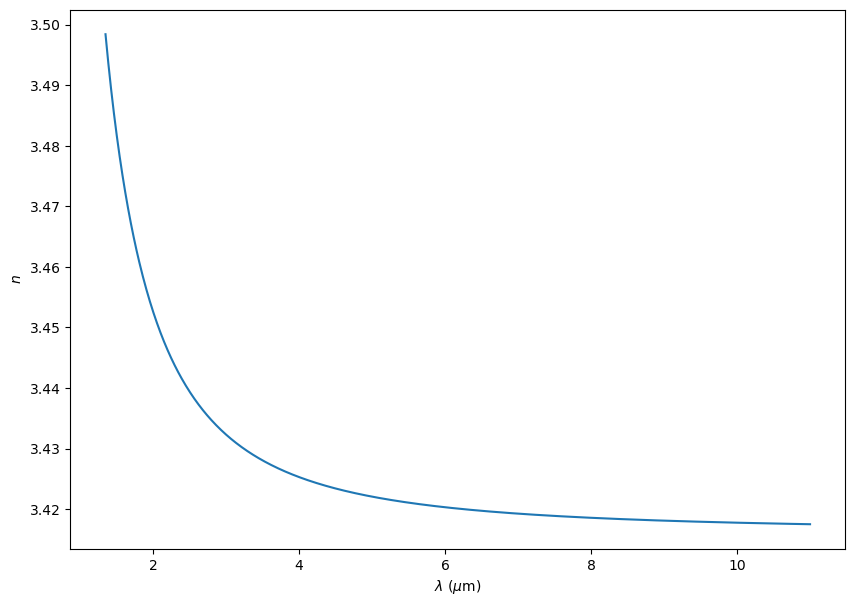

In [8]:
y = np.linspace(1.35, 11, 1000)

B_si = [10.6684293, 0.0030434748, 1.54133408]
C_si = [0.301516485**2, 1.13475115**2, 1104**2]

n_si = n_sell(y, B_si, C_si)

fig = plt.figure()
fig.set_size_inches(10, 7)

plt.plot(y, n_si)
plt.xlabel('$\lambda$ ($\mu$m)')
plt.ylabel('$n$');

Note the index change as a function of wavelength.  Since the phase accumulated in propagation goes as $\varphi = 2\pi n(\lambda) L/\lambda$ where $L$ is the propagation length, this leads to phase dispersion on an outgoing pulse after propagation.

#### Pulse Propagation Through Real Materials

The purpose of the interactive code below is to compare pulse propagation through various thicknesses of two example materials: SF10, Si, and BK7.  Pick a material and adjust the thickness to observe how the pulse is reshaped.  

Note in the calculation that we remove the time-shift from the group velocity term.  This is important for numerical computations! (For example, try removing it and see what happens). 

In [9]:
#Retrieve values after setting pulse above
wc, fwhm, t_ax, A, E = pulse_set.result

#Take the FT of the envelope
A_f = np.fft.fft(A)

#Define the frequency axis
dt = t_ax[1] - t_ax[0]
w = 2*np.pi*np.fft.fftfreq(E.size, dt)

k0 = (w + wc)*1e15*1e-6/c #Be careful of units here!
y = 2*np.pi/k0 #wavelength in microns from our pulse

#Si coefficients
B_si = [10.6684293, 0.0030434748, 1.54133408]
C_si = [0.301516485**2, 1.13475115**2, 1104**2]
n_si = n_sell(y, B_si, C_si)

#SF10 coefficients
B_sf10 = [1.62153902, 0.256287842, 1.64447552]
C_sf10 = [0.0122241457, 0.0595736775, 147.468793]
n_sf10 = n_sell(y, B_sf10, C_sf10)

#BK7 coefficients
B_bk7 = [1.03961212, 0.231792344, 1.01046945]
C_bk7 = [0.00600069867, 0.0200179144, 103.560653]
n_bk7 = n_sell(y, B_bk7, C_bk7)

#Function to re-calculate the outgoing pulse and update the plotting when user selects different phi_n values:
def update(mat_choice, L):
    
    n_mat = np.ones(y.size)
    if(mat_choice == 1):
        n_mat = n_si
    elif(mat_choice == 2):
        n_mat = n_sf10
    elif(mat_choice == 3):
        n_mat = n_bk7
    
    k_mat = k0*n_mat
    
    #We need to take the group delay out!
    vg = (w[1] - w[0])/(k_mat[1] - k_mat[0])
    t_delay = L/vg
    
    phi = -1*k_mat*L + w*t_delay
    
    H = np.exp(1j*phi)
    
    #Calculate outputs:
    A_out_f = A_f*H
    A_out = np.fft.ifft(A_out_f)
    
    #Update plots
    fig = plt.figure()
    fig.set_size_inches(10, 7)
    
    ax = []
    ax.append(fig.add_subplot(1,1,1))
    
    #-- Plot Outgoing Pulse Intensity in Time --
    ax[0].plot(t_ax, np.abs(A)**2, label='Input')
    ax[0].plot(t_ax, np.abs(A_out/np.abs(A_out).max())**2, label='Output')
    ax[0].set_xlabel('Time (fs)')
    ax[0].set_ylabel('$|A|^2$')
    ax[0].set_xlim(-10*fwhm, 10*fwhm)
    
    ax[0].legend()


disperse = ipywidgets.interactive(update, 
                       mat_choice = ipywidgets.Dropdown(
                                options=[('Si', 1), ('SF10', 2), ('BK7', 3)],
                                value=1,
                                description='Material:'),
                       L=ipywidgets.FloatText(value=0.0, description='L ($\mu$m)'))

display(disperse)

interactive(children=(Dropdown(description='Material:', options=(('Si', 1), ('SF10', 2), ('BK7', 3)), value=1)…

### Pulse Stretching and Compressing With Material Dispersion

This demonstration shows how normal and anomalous dispersion can be combined for pulse stretching and compression.  For a wavelength of 1550 nm, silicon exhibits a positive GVD, while BK7 exhibits a negative GVD.  This means that they can be combined at varying thicknesses for pulse stretching and then compression.

**Questions**

 1. For a 30 fs pulse at 1550 nm, approximately how thick of a BK7 glass is needed to compress a the pulse when it is stretched by 2 mm of silicon?  

 2. While this can add and remove GDD, what about higher-order dispersion?  What about the results indicates reidual higher-order dispersion?  
 
 3. What order do you expect is dominant and why?
 
 4. What sign is it and why?  

**Note:** This demonstration is intended to be run using a pulse having central wavelength of 1550 nm.

In [10]:
#Retrieve values after setting pulse above
wc, fwhm, t_ax, A, E = pulse_set.result

#Take the FT of the envelope
A_f = np.fft.fft(A)

#Define the frequency axis
dt = t_ax[1] - t_ax[0]
w = 2*np.pi*np.fft.fftfreq(E.size, dt)


k0 = (w + wc)*1e15*1e-6/c #Be careful of units here!
y = 2*np.pi/k0 #wavelength in microns from our pulse

#Si coefficients
B_si = [10.6684293, 0.0030434748, 1.54133408]
C_si = [0.301516485**2, 1.13475115**2, 1104**2]
n_si = n_sell(y, B_si, C_si)

#BK7 coefficients
B_bk7 = [1.03961212, 0.231792344, 1.01046945]
C_bk7 = [0.00600069867, 0.0200179144, 103.560653]
n_bk7 = n_sell(y, B_bk7, C_bk7)

#Function to re-calculate the outgoing pulse and update the plotting when user selects different phi_n values:
def update(L_bk7, L_si):
    
    
    k_bk7 = k0*n_bk7
        
    vg_bk7 = (w[1] - w[0])/(k_bk7[1] - k_bk7[0])
    
    t_delay_bk7 = L_bk7/vg_bk7
    
    
    k_si = k0*n_si
        
    vg_si = (w[1] - w[0])/(k_si[1] - k_si[0])
    
    t_delay_si = L_si/vg_si
    
    phi = -1*k_si*L_si - k_bk7*L_bk7 +  w*(t_delay_si + t_delay_bk7)
    
    H = np.exp(1j*phi)
    
    #Calculate outputs:
    A_out_f = A_f*H
    A_out = np.fft.ifft(A_out_f)
    
    #Update plots
    fig = plt.figure()
    fig.set_size_inches(10, 7)
    
    ax = []
    ax.append(fig.add_subplot(1,1,1))
    
    #-- Plot Outgoing Pulse Intensity in Time --
    ax[0].plot(t_ax, np.abs(A)**2, label='Input')
    ax[0].plot(t_ax, np.abs(A_out/np.abs(A_out).max())**2, label='Output')
    ax[0].set_xlabel('Time (fs)')
    ax[0].set_ylabel('$|A|^2$')
    ax[0].set_xlim(-10*fwhm, 10*fwhm)
    
    ax[0].legend()


disperse = ipywidgets.interactive(update, 
                       L_bk7=ipywidgets.FloatText(value=0.0, description='L BK7 ($\mu$m)'),
                       L_si=ipywidgets.FloatText(value=2000, description='L Si ($\mu$m)'))

display(disperse)

interactive(children=(FloatText(value=0.0, description='L BK7 ($\\mu$m)'), FloatText(value=2000.0, description…